In [11]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sn
%matplotlib inline
plt.style.use('fivethirtyeight')

In [22]:
with open ('../models/catboost.pkl', 'rb') as f:
    clf = pickle.load(f)
    
df = pd.read_csv('../data/Task2data.csv')
y = df.pop('fraud')

X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=7, stratify=y)

In [23]:
preds_proba = clf.predict_proba(X_test)[:, 1]

In [7]:
y.sum() / 98

27.081632653061224

In [ ]:
total_fraud_per_hour = df.groupby('hour1').fraud.sum() / 98
print (total_fraud_per_hour[:8].sum())
print (total_fraud_per_hour[8:18].sum())
print (total_fraud_per_hour[18:].sum())

In [126]:
cb_matrix = pd.DataFrame(data=[[0, -2], [-45.00, -2]], index=['Legal', 'Fraud'], columns=['Legal', 'Fraud'])
cb_matrix.index.name = 'actual'
cb_matrix.columns.name = 'predicted'
cb_matrix

predicted,Legal,Fraud
actual,,
Legal,0.0,-2
Fraud,-45.0,-2


#### Start by looking at out model's default confusion matrix
You can see that we only correctly identify just over half of our fraud labels. <br>
In some business scenarios this would not be very good, however note that our typical transaction amount is not very high.

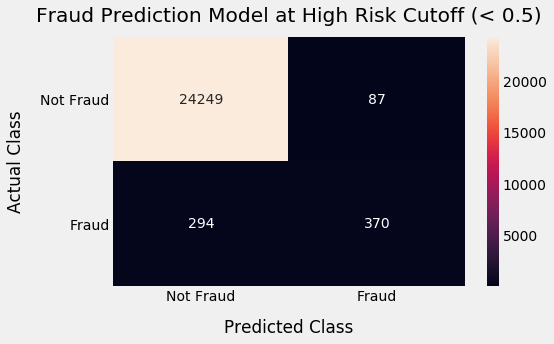

In [101]:
fig, ax = plt.subplots(figsize=(8, 5))
confusion_matrix = metrics.confusion_matrix(y_test, (preds_proba > .5).astype(int))

sn.heatmap(confusion_matrix, fmt='', annot=True, cbar=True, ax=ax)
ax.set_xlabel('Predicted Class', labelpad=15)
ax.xaxis.set_ticklabels(['Not Fraud', 'Fraud'])
ax.set_ylabel('Actual Class', labelpad=15)
ax.yaxis.set_ticklabels(['Not Fraud', 'Fraud'], rotation=360)
ax.set_title('Fraud Prediction Model at High Risk Cutoff (< 0.5)', pad=15)
fig.tight_layout()
#plt.savefig('confusion_default.png')

In [81]:
def calculate_payout(cb, y_true, probabilities, threhold):
    preds = (probabilities > threshold).astype(int)
    confusion_matrix = metrics.confusion_matrix(y_true, preds)
    payout = (cb * confusion_matrix).values.sum()
    return payout

In [56]:
thresholds = np.arange(0.1, 1.0, 0.1)
for threshold in thresholds:
    print(calculate_payout(cb_matrix, y_test, preds_proba, threshold))
    

8008.0
9872.0
10280.0
10552.0
10632.0
10568.0
10416.0
10184.0
9656.0


Text(0.5, 1.0, 'Profit Curve -- Maximizing Threshold at 0.05')

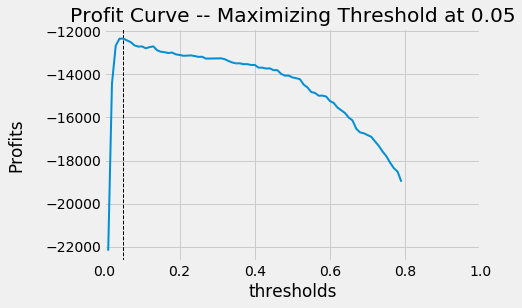

In [128]:
thresholds = np.arange(0.1, 1.0, 0.01)
profits = []
for threshold in thresholds:
    profits.append(calculate_payout(cb_matrix, y_test, preds_proba, threshold))
max_profit = thresholds[np.argmax(profits)]

fig, ax = plt.subplots()
ax.axvline(max_profit, linewidth=1, linestyle='--', color='k')
ax.plot(thresholds, profits, linewidth=2)

ax.set_xlim([0,1])
ax.set_xlabel('thresholds')
ax.set_ylabel('Profits', labelpad=20)
ax.set_title(f'Profit Curve -- Maximizing Threshold at {round(max_profit, 3)}')

In [9]:
def base_cost(n):
    dly_sales = [[994, 0],[n*4, 26-(n*4)]]
    fraud = np.zeros(1020)
    fraud[:26] = 1
    preds = fraud.copy()
    preds[:n*4] = 0
    return dly_sales, fraud, preds

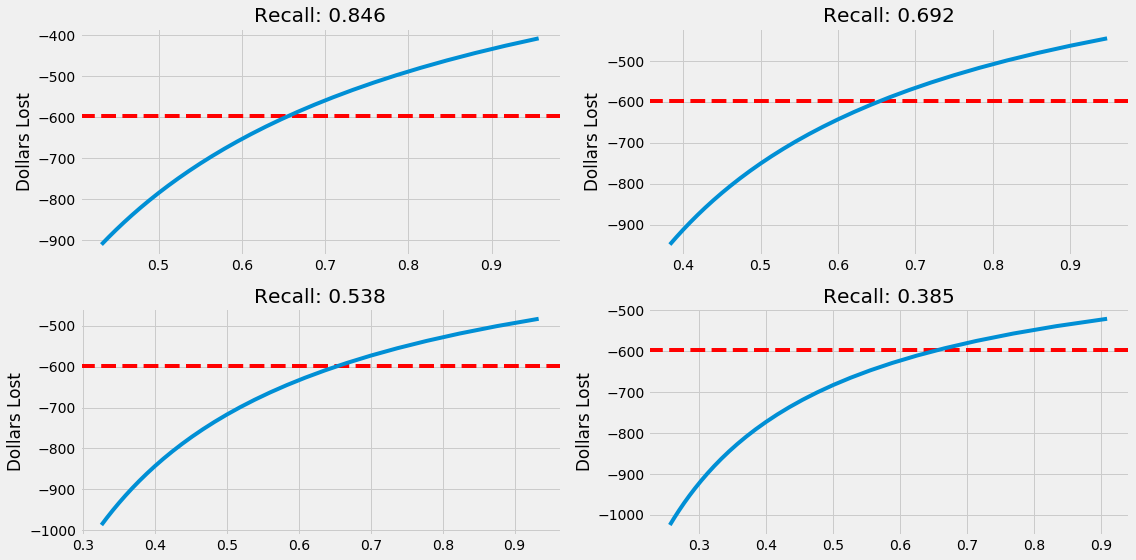

In [15]:
cb = pd.DataFrame(data=[[0.0, -18.00], [-23.00, -13.50]])
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
for i, ax in enumerate(axs.flatten()):
    dly_sales, fraud, preds = base_cost(i+1)
    loss, precision = [], []
    for n in range(1, 30):
        dly_sales[0][0] -= 1
        dly_sales[0][1] += 1
        preds[-n:] = 1
        est = (dly_sales*cb.values).sum()
        loss.append(est)
        precision.append(metrics.precision_score(fraud, preds))
        if est < - 598:
            opt = metrics.precision_score(fraud, preds)
        
    ax.axhline(-598, linestyle='--', color='r')
    ax.plot(precision, loss)
    ax.set_ylabel('Dollars Lost')
    #ax.set_xlabel('Precision Score')
    ax.set_title('Recall: %.3f'%metrics.recall_score(fraud, preds))

fig.tight_layout()
#plt.savefig('visuals/Recall_Precision.png');

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
cb = pd.DataFrame(data=[[0.0, -18.00], [-23.00, -13.50]])
for i, ax in enumerate(axs.flatten()):
    dly_sales, fraud, preds = base_cost(i+1)
    loss, precision = [], []
    cb.iloc[0,1] += 4
    cost_to_fp = cb.iloc[0,1]
    opt = 0
    for n in range(1, 14):
        dly_sales[0][0] -= 20
        dly_sales[0][1] += 20
        preds[-n*20:] = 1
        est = (dly_sales*cb.values).sum()
        loss.append(est)
        precision.append(precision_score(fraud, preds))
        if est < - 715 and opt == 0:
            opt = round(recall_score(fraud, preds), 2)
    ax.axhline(-715, linestyle='--', color='r')
    ax.plot(precision, loss)
    ax.set_ylabel('Dollars Lost')
    #ax.set_xlabel('Precision Score')
    ax.set_title(f'Recall: {opt}   |   ${-cost_to_fp} to investigate FPs')

fig.tight_layout()
#plt.savefig('visuals/declingcosts.png')

In [ ]:
np.round(roc_auc_score(fraud, preds),4)

29937    True
83615    True
59774    True
6161     True
9609     True
         ... 
81356    True
26487    True
90863    True
71153    True
74349    True
Name: fraud, Length: 25000, dtype: bool

In [114]:
y_test.loc[~(y_test == (preds_proba > 0.5).astype(int))]

46974    1.0
18914    1.0
61822    1.0
60679    1.0
47485    0.0
        ... 
24346    1.0
61622    1.0
71442    1.0
35026    1.0
89203    1.0
Name: fraud, Length: 381, dtype: float64

In [124]:
X_test.loc[y_test.index[~(y_test == (preds_proba > 0.5).astype(int))]]

,amount,hour,zip1,id#,field2,flag1,field3,field4,indicator1,indicator2,flag2,flag3,flag4,flag5,field1_0,field1_1,field1_2,field1_3
46974,12.95,16,554,1234567890159596,0,1,-1453,8,0,0,0,0,0,1,0,0,0,1
18914,12.95,9,633,1234567890138700,1,0,6274,33,0,0,0,0,0,1,0,0,0,1
61822,10.36,18,945,1234567890170332,0,0,238,21,0,0,1,1,0,1,0,0,1,0
60679,12.95,17,986,1234567890169550,0,0,421,19,0,0,0,1,0,1,0,1,0,0
47485,38.85,4,920,1234567890159959,0,0,-312,19,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24346,12.95,13,274,1234567890142886,0,0,-3399,22,0,0,0,0,0,1,0,0,0,1
61622,38.85,16,900,1234567890169888,1,0,-17431,20,0,0,1,0,0,1,0,0,0,1
71442,12.95,11,20,1234567890177129,1,1,2210,14,0,0,0,0,0,1,0,0,0,1
35026,12.95,19,606,1234567890150838,1,0,5036,17,0,0,0,0,0,1,0,0,0,1


In [123]:
X_test.loc[y_test.index[(y_test == (preds_proba > 0.5).astype(int))]].amount.mean()

27.16503635402927